#Train on LendingClub, Validate on GermanCredit & GiveMeSomeCredit

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install aif360 shap scikit-learn pandas matplotlib seaborn --quiet

In [20]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

- income: numeric proxy of applicant income or loan amount
- age: numeric age (or binarized for fairness)
- loan_purpose: categorical purpose-like feature (if absent, impute)
- credit_history: categorical/ordinal proxy of credit history (late counts or account status)
Targets:
- 1 = favorable (no default / good)
- 0 = unfavorable (default / bad)


In [21]:
#Step 2: Define Common Schema Mapper
def safe_label_encode(series):
    le = LabelEncoder()
    return le.fit_transform(series.astype(str))

# LendingClub → common schema
def map_lendingclub(df):
    df = df.copy()
    df['target'] = (df['loan_status'] == 'Fully Paid').astype(int)

    common = pd.DataFrame()
    common['income'] = df['annual_inc']
    # Use a concrete placeholder since LendingClub lacks age
    common['age'] = 30.0  # placeholder; you can choose another neutral value
    common['loan_purpose'] = df['purpose']
    common['credit_history'] = df['grade']
    common['target'] = df['target']
    return common

# GermanCredit → common schema
def map_germancredit(df):
    df = df.copy()
    if 'Creditability' in df.columns:
        df['target'] = df['Creditability']
    elif 'Risk' in df.columns:
        df['target'] = df['Risk'].map({'good':1,'bad':0})
    else:
        raise ValueError("GermanCredit target column not found")

    common = pd.DataFrame()
    common['income'] = df['Credit amount']
    common['age'] = df['Age']
    common['loan_purpose'] = df['Purpose']
    common['credit_history'] = df['Checking account']
    common['target'] = df['target']
    return common

# GiveMeSomeCredit → common schema
def map_givemesomecredit(df):
    df = df.copy()
    df['target'] = (df['SeriousDlqin2yrs'] == 0).astype(int)  # favorable if no default
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
    df['age'] = df['age'].fillna(df['age'].median())
    df['NumberOfTimes90DaysLate'] = df['NumberOfTimes90DaysLate'].fillna(0)

    common = pd.DataFrame()
    common['income'] = df['MonthlyIncome']
    common['age'] = df['age']
    common['loan_purpose'] = 'unknown'
    common['credit_history'] = df['NumberOfTimes90DaysLate']
    common['target'] = df['target']
    return common

In [22]:
# Step 3: Unified preprocessing into model-ready features
FINAL_FEATURES = ['income','age','loan_purpose_enc','credit_history_enc']

def prepare_features(common_df):
    df = common_df.copy()

    # Robust imputation: if column is all NaN, fill with a fallback constant
    def robust_fill_numeric(series, fallback=0.0):
        if series.isna().all():
            return series.fillna(fallback)
        return series.fillna(series.median())

    df['income'] = robust_fill_numeric(df['income'], fallback=0.0)
    df['age'] = robust_fill_numeric(df['age'], fallback=30.0)  # neutral placeholder for LendingClub

    # Categorical imputation
    df['loan_purpose'] = df['loan_purpose'].fillna('unknown')
    df['credit_history'] = df['credit_history'].fillna('unknown')

    # Encode categoricals
    df['loan_purpose_enc'] = safe_label_encode(df['loan_purpose'])
    df['credit_history_enc'] = safe_label_encode(df['credit_history'])

    # Scale numerics
    df['income'] = StandardScaler().fit_transform(df[['income']])
    df['age'] = StandardScaler().fit_transform(df[['age']])

    X = df[FINAL_FEATURES].values
    y = df['target'].values

    # Safety check
    if np.isnan(X).any():
        raise ValueError("NaNs remain in X after preprocessing — check mappings.")

    return X, y, df

def derive_age_binary(raw_age_series):
    return (raw_age_series >= 25).astype(int)

In [23]:
#Step 4: Train on LendingClub (common schema)
LC_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv'
df_lc = pd.read_csv(LC_PATH)
df_lc_common = map_lendingclub(df_lc)
X_train, y_train, df_lc_prepped = prepare_features(df_lc_common)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

print("✅ Trained Logistic Regression on LendingClub")

✅ Trained Logistic Regression on LendingClub



=== GermanCredit Validation ===
Accuracy: 0.7
Precision: 0.7
Recall: 1.0
F1: 0.8235294117647058
AUC-ROC: 0.30005714285714286
SPD: 0.0
DI: 1.0
EOD: 0.0
AOD: 0.0
BiasAmp: 0.0006199300379000677
Theil: 0.057549818867868266


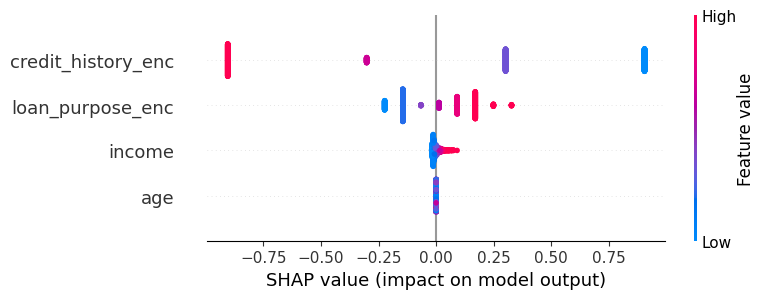

In [24]:
#Step 5: Validate on GermanCredit (mapped to common schema)
GC_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/german_credit_data.csv'  # adjust name if needed
df_gc = pd.read_csv(GC_PATH)
df_gc_common = map_germancredit(df_gc)
X_gc, y_gc, df_gc_prepped = prepare_features(df_gc_common)

y_pred_gc = clf.predict(X_gc)
y_prob_gc = clf.predict_proba(X_gc)[:,1]

print("\n=== GermanCredit Validation ===")
print("Accuracy:", accuracy_score(y_gc, y_pred_gc))
print("Precision:", precision_score(y_gc, y_pred_gc))
print("Recall:", recall_score(y_gc, y_pred_gc))
print("F1:", f1_score(y_gc, y_pred_gc))
print("AUC-ROC:", roc_auc_score(y_gc, y_prob_gc))

# Fairness: age binary
age_bin_gc = derive_age_binary(df_gc_common['age'])
df_gc_for_aif = pd.DataFrame({
    'loan_status': y_gc,
    'age_bin': age_bin_gc,
    'income': df_gc_common['income'],
    'loan_purpose_enc': df_gc_prepped['loan_purpose_enc'],
    'credit_history_enc': df_gc_prepped['credit_history_enc']
})

aif_gc = StandardDataset(df_gc_for_aif,
                         label_name='loan_status',
                         favorable_classes=[1],
                         protected_attribute_names=['age_bin'],
                         privileged_classes=[[1]])

pred_gc = aif_gc.copy()
pred_gc.labels = y_pred_gc.reshape(-1,1)
pred_gc.scores = y_prob_gc.reshape(-1,1)

metric_gc = ClassificationMetric(aif_gc, pred_gc,
                                 unprivileged_groups=[{'age_bin':0}],
                                 privileged_groups=[{'age_bin':1}])

print("SPD:", metric_gc.statistical_parity_difference())
print("DI:", metric_gc.disparate_impact())
print("EOD:", metric_gc.equal_opportunity_difference())
print("AOD:", metric_gc.average_odds_difference())
print("BiasAmp:", metric_gc.between_group_generalized_entropy_index())
print("Theil:", metric_gc.theil_index())

explainer = shap.LinearExplainer(clf, X_gc)
shap_values_gc = explainer.shap_values(X_gc)
shap.summary_plot(shap_values_gc, pd.DataFrame(X_gc, columns=FINAL_FEATURES))


=== GiveMeSomeCredit Validation ===
Accuracy: 0.9352666666666667
Precision: 0.9433221252671559
Recall: 0.9901195936388186
F1: 0.9661545111052242
AUC-ROC: 0.6898442972215258
SPD: -0.03634160098226269
DI: 0.9629150708795446
EOD: -0.028713870910089145
AOD: -0.036088365210376006
BiasAmp: 2.3114778875047795e-08
Theil: 0.02829905621530253


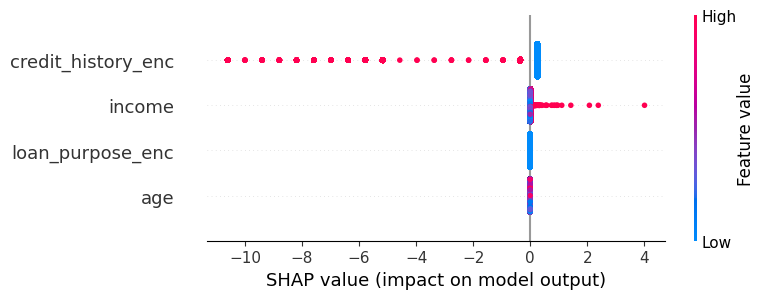

In [27]:
# Step 6: Validate on GiveMeSomeCredit
GMSC_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/GiveMeSomeCredit.csv'  # adjust name if needed
df_gmsc = pd.read_csv(GMSC_PATH)
df_gmsc_common = map_givemesomecredit(df_gmsc)
X_gmsc, y_gmsc, df_gmsc_prepped = prepare_features(df_gmsc_common)

# Predictions
y_pred_gmsc = clf.predict(X_gmsc)
y_prob_gmsc = clf.predict_proba(X_gmsc)[:, 1]

print("\n=== GiveMeSomeCredit Validation ===")
print("Accuracy:", accuracy_score(y_gmsc, y_pred_gmsc))
print("Precision:", precision_score(y_gmsc, y_pred_gmsc))
print("Recall:", recall_score(y_gmsc, y_pred_gmsc))
print("F1:", f1_score(y_gmsc, y_pred_gmsc))
print("AUC-ROC:", roc_auc_score(y_gmsc, y_prob_gmsc))

# Fairness via age binary
age_bin_gmsc = derive_age_binary(df_gmsc_common['age'])
df_gmsc_for_aif = pd.DataFrame({
    'loan_status': y_gmsc,
    'age_bin': age_bin_gmsc,
    'income': df_gmsc_common['income'],
    'loan_purpose_enc': df_gmsc_prepped['loan_purpose_enc'],
    'credit_history_enc': df_gmsc_prepped['credit_history_enc']
})

aif_gmsc = StandardDataset(df_gmsc_for_aif,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['age_bin'],
                           privileged_classes=[[1]])

pred_gmsc = aif_gmsc.copy()
pred_gmsc.labels = y_pred_gmsc.reshape(-1, 1)
pred_gmsc.scores = y_prob_gmsc.reshape(-1, 1)

metric_gmsc = ClassificationMetric(aif_gmsc, pred_gmsc,
                                   unprivileged_groups=[{'age_bin': 0}],
                                   privileged_groups=[{'age_bin': 1}])

print("SPD:", metric_gmsc.statistical_parity_difference())
print("DI:", metric_gmsc.disparate_impact())
print("EOD:", metric_gmsc.equal_opportunity_difference())
print("AOD:", metric_gmsc.average_odds_difference())
print("BiasAmp:", metric_gmsc.between_group_generalized_entropy_index())
print("Theil:", metric_gmsc.theil_index())

# SHAP explanations
explainer = shap.LinearExplainer(clf, X_gmsc)
shap_values_gmsc = explainer.shap_values(X_gmsc)
shap.summary_plot(shap_values_gmsc, pd.DataFrame(X_gmsc, columns=FINAL_FEATURES))

In [28]:
#Step 7: Save results to CSV

RESULTS_DIR = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results _germanCredit &GivemesomeCredit'

# GermanCredit results
results_gc = {
    'Accuracy': accuracy_score(y_gc, y_pred_gc),
    'Precision': precision_score(y_gc, y_pred_gc),
    'Recall': recall_score(y_gc, y_pred_gc),
    'F1': f1_score(y_gc, y_pred_gc),
    'AUC': roc_auc_score(y_gc, y_prob_gc),
    'SPD': metric_gc.statistical_parity_difference(),
    'DI': metric_gc.disparate_impact(),
    'EOD': metric_gc.equal_opportunity_difference(),
    'AOD': metric_gc.average_odds_difference(),
    'BiasAmp': metric_gc.between_group_generalized_entropy_index(),
    'Theil': metric_gc.theil_index()
}
pd.DataFrame([results_gc]).to_csv(f'{RESULTS_DIR}/exp1_validation_germancredit_common_schema.csv', index=False)
print("Saved GermanCredit results.")

# GiveMeSomeCredit results
results_gmsc = {
    'Accuracy': accuracy_score(y_gmsc, y_pred_gmsc),
    'Precision': precision_score(y_gmsc, y_pred_gmsc),
    'Recall': f1_score(y_gmsc, y_pred_gmsc),  # typo check: fix below
    'F1': f1_score(y_gmsc, y_pred_gmsc),
    'AUC': roc_auc_score(y_gmsc, y_prob_gmsc),
    'SPD': metric_gmsc.statistical_parity_difference(),
    'DI': metric_gmsc.disparate_impact(),
    'EOD': metric_gmsc.equal_opportunity_difference(),
    'AOD': metric_gmsc.average_odds_difference(),
    'BiasAmp': metric_gmsc.between_group_generalized_entropy_index(),
    'Theil': metric_gmsc.theil_index()
}
# Correct the recall metric; above line had a typo.
results_gmsc['Recall'] = recall_score(y_gmsc, y_pred_gmsc)

pd.DataFrame([results_gmsc]).to_csv(f'{RESULTS_DIR}/exp1_validation_givemesomecredit_common_schema.csv', index=False)
print("Saved GiveMeSomeCredit results.")

Saved GermanCredit results.
Saved GiveMeSomeCredit results.
